In [10]:
import gzip
import math
import numpy as np
import random
import pandas as pd
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
from gensim.models import Word2Vec
import dateutil
from scipy.sparse import lil_matrix # To build sparse feature matrices, if you like
import requests
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Run this if to download datafile to local
# URL of the gzipped JSON file
url = "https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/review-Hawaii_10.json.gz"

# Define a local file to save the gzipped content
local_file = "review-Hawaii.json.gz"

# Download the file in chunks
with requests.get(url, stream=True) as response:
    response.raise_for_status()  # Raise an error if the download fails
    with open(local_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):  # Adjust chunk size as needed
            f.write(chunk)

In [3]:
# Decompress and load the JSON data
local_file = "review-Hawaii.json.gz"
dataset_review_Hawaii = []
with gzip.open(local_file, "rt", encoding="utf-8") as f:  # "rt" mode for text
    for line in f:
        data = json.loads(line)  # Parse each JSON object
        dataset_review_Hawaii.append(data)

# Output the length of the dataset to verify
print(f"Loaded {len(dataset_review_Hawaii)} reviews.")

Loaded 1504347 reviews.


In [4]:
review_Hawaii_clean = [i for i in dataset_review_Hawaii if i['text'] != None]
review_Hawaii_clean = pd.DataFrame(review_Hawaii_clean)
review_Hawaii_clean_eng = review_Hawaii_clean[review_Hawaii_clean['text'].str.match(r'\w')]
review_Hawaii_clean_eng

,user_id,name,time,rating,text,pics,resp,gmap_id
0,113965417079576625433,manuel grimaldo,1591839903487,5,Great new upgrade,None,None,0x7c00159b5b1b1d25:0x8d2d85d4a758290e
1,109623613356773809039,Vicki Kach,1579559747146,5,So pleased to find Dr. Mike! He’s the real de...,None,None,0x7c006de89f2d86e1:0x23d998532e9317a6
2,105786704025048642479,Jessica Clopton,1545530647643,1,"The doctor is extremely creepy. First of all, ...",None,None,0x7c006de89f2d86e1:0x23d998532e9317a6
3,117458106933327014012,Robin Hanlin,1561877267351,5,As a former R.N. was looking for big shoes to ...,None,"{'time': 1561923354957, 'text': 'Thank you so ...",0x7c006de89f2d86e1:0x23d998532e9317a6
4,108985244966294061730,Connie Mark,1580241584528,5,Great place! Doctor helped my body pains.,None,None,0x7c006de89f2d86e1:0x23d998532e9317a6
...,...,...,...,...,...,...,...,...
852568,107984868534067220088,Joshua Collier,1530714878067,2,Wish they would let you explore the area more ...,None,None,0x7953b4a4114e37f7:0x374b5a1f84f48a1a
852569,110628723873286096539,Stefano Parvoli,1528753144886,5,Amazing,None,None,0x7953b4a4114e37f7:0x374b5a1f84f48a1a
852570,107169846833534902263,Christine Lominario,1519620209920,5,Majestic 😊,None,None,0x7953b4a4114e37f7:0x374b5a1f84f48a1a
852571,101666345935879309455,Allana Kate,1517440381978,5,Amazing,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x7953b4a4114e37f7:0x374b5a1f84f48a1a


#### Data Analysis

In [5]:
review_Hawaii_feature = review_Hawaii_clean_eng[['user_id', 'gmap_id', 'text', 'rating']]
review_Hawaii_feature.head(100)

,user_id,gmap_id,text,rating
0,113965417079576625433,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,Great new upgrade,5
1,109623613356773809039,0x7c006de89f2d86e1:0x23d998532e9317a6,So pleased to find Dr. Mike! He’s the real de...,5
2,105786704025048642479,0x7c006de89f2d86e1:0x23d998532e9317a6,"The doctor is extremely creepy. First of all, ...",1
3,117458106933327014012,0x7c006de89f2d86e1:0x23d998532e9317a6,As a former R.N. was looking for big shoes to ...,5
4,108985244966294061730,0x7c006de89f2d86e1:0x23d998532e9317a6,Great place! Doctor helped my body pains.,5
...,...,...,...,...
98,113954467402806825801,0x795406d3728f9b1b:0x236996c8f711cda8,Great place,3
99,117257970158561722599,0x795406d3728f9b1b:0x236996c8f711cda8,Incredible,5
100,117345116162370485994,0x7c0015d64cd48c6f:0x4cac932764bd2fac,This Kitty Cafe was MEOWzing! There were so ma...,5
101,118397406534237711570,0x7c0015d64cd48c6f:0x4cac932764bd2fac,"Friendly owners, fun thematic decor, and lots ...",5


In [6]:
# Split the review_Hawaii_feature into train (80%) and test (20%) datasets
trainData, testData = train_test_split(review_Hawaii_feature, test_size=0.2, random_state=42)

# Optionally, you can reset indices of both DataFrames if needed
trainData.reset_index(drop=True, inplace=True)
testData.reset_index(drop=True, inplace=True)

In [7]:
rating_counts = review_Hawaii_feature['rating'].value_counts().sort_index()

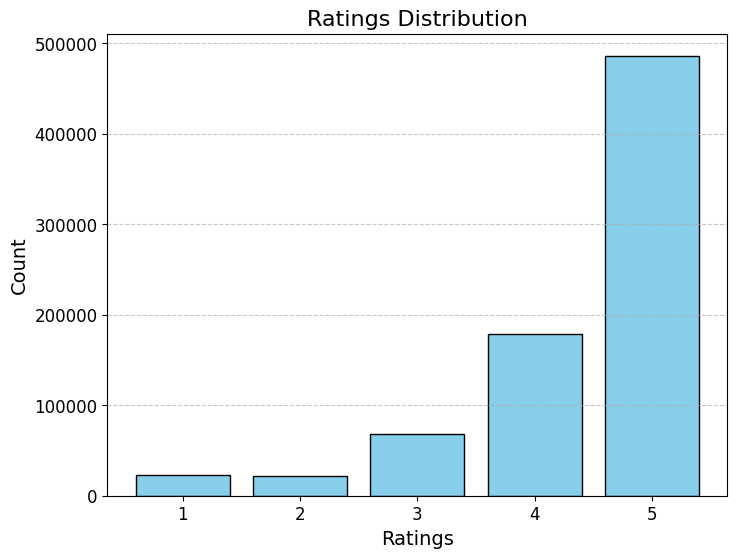

In [11]:
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
plt.title('Ratings Distribution', fontsize=16)
plt.xlabel('Ratings', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rating_counts.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 1. sim - user_id v.s. gmap_id predict rating

In [12]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
# itemNames = {}
ratingDict = {} # To retrieve a rating for a specific user/item pair

for _, d in trainData.iterrows():
    user,item = d['user_id'], d['gmap_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    ratingDict[(user,item)] = d['rating']
    # itemNames[item] = d['product_title']

In [13]:
def MSE(y_true, y_pred):
    differences = [(x-y)**2 for x,y in zip(y_true,y_pred)]
    return sum(differences) / len(differences)

In [14]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [15]:
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [16]:
ratingMean = sum([d['rating'] for _, d in trainData.iterrows()]) / len(trainData)

In [17]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

##### 1. Using user-user similarity with Jaccard predict

In [18]:
def predictRating_Jaccard(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['gmap_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        ratingPrediction = itemAverages[item] + sum(weightedRatings) / sum(similarities)
        return max(1, min(5, ratingPrediction))
    else:
        # User hasn't rated any similar items
        return ratingMean

In [19]:
simPredictions = [predictRating_Jaccard(d['user_id'], d['gmap_id']) for _, d in testData.iterrows()]

In [20]:
mse_jaccard_user_train = MSE([d['rating'] for _, d in trainData.iterrows()], [predictRating_Jaccard(d['user_id'], d['gmap_id']) for _, d in trainData.iterrows()])
mse_jaccard_user_train

0.7327708827118294

In [21]:
true_rating = [d['rating'] for _, d in testData.iterrows()]
mse_jaccard_user = MSE(simPredictions, true_rating)

print("Jaccard User-based MSE: ", mse_jaccard_user)

Jaccard User-based MSE:  0.8033548695931364


##### 2. Using user-user similarity with Cosine predict

In [22]:
# based on user-user similarity with Cosine
def predictRating_cos(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['gmap_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Cosine(item,i2))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        ratingPrediction = itemAverages[item] + sum(weightedRatings) / sum(similarities)
        return max(1, min(5, ratingPrediction))
    else:
        # User hasn't rated any similar items
        return ratingMean

In [23]:
simPredictions = [predictRating_cos(d['user_id'], d['gmap_id']) for _, d in testData.iterrows()]

In [24]:
true_rating = [d['rating'] for _, d in testData.iterrows()]
mse_consin_user = MSE(simPredictions, true_rating)

print("Cosine User-based MSE: ", mse_consin_user)

Cosine User-based MSE:  0.7981501661010038


In [25]:
mse_cosin_user_train = MSE([d['rating'] for _, d in trainData.iterrows()], [predictRating_cos(d['user_id'], d['gmap_id']) for _, d in trainData.iterrows()])
mse_cosin_user_train

0.705648024413823

##### 3. Using user-user similarity with Jaccard predict with weight

In [26]:
#based on user-user similarity Jaccard with weight
def predictRating_Jaccard_weight(user,item, weight):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['gmap_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(pow(Jaccard(usersPerItem[item],usersPerItem[i2]), weight))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        ratingPrediction = itemAverages[item] + sum(weightedRatings) / sum(similarities)
        return max(1, min(5, ratingPrediction))
    else:
        # User hasn't rated any similar items
        return ratingMean

In [27]:
weights = [0.1, 0.2, 0.3, 0.4, 0.5]
best_weight = None
best_MSE = None
for weight in weights:
    simPredictions = [predictRating_Jaccard_weight(d['user_id'], d['gmap_id'], weight) for _, d in testData.iterrows()]
    true_rating = [d['rating'] for _, d in testData.iterrows()]
    print(f"Weight: {weight}, MSE: {MSE(simPredictions, true_rating)}")
    if best_weight is None or MSE(simPredictions, true_rating) < best_MSE:
        best_weight = weight
        best_MSE = MSE(simPredictions, true_rating)

print(f"Best weight: {best_weight}")

mse_best_jaccard = best_MSE

Weight: 0.1, MSE: 0.7861046558647632
Weight: 0.2, MSE: 0.7855306330473113
Weight: 0.3, MSE: 0.7857011791025986
Weight: 0.4, MSE: 0.7865753351540586
Weight: 0.5, MSE: 0.7880943934270958
Best weight: 0.2


### 2. text mining - text predict rating

#### 1. Bag-of-words models

In [28]:
import nltk
from nltk.corpus import stopwords

In [29]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79250\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
#Ignore capitalization and remove punctuation
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

for d in review_Hawaii_feature['text']:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        if w not in stop_words:
            wordCount[w] += 1

len(wordCount)

150685

In [31]:
count = []
for w in wordCount:
    count.append((wordCount[w],w))
count.sort(reverse=True)
words = [x[1] for x in count[:1000]]
words

['great',
 'food',
 'good',
 'place',
 'service',
 'nice',
 'get',
 'friendly',
 'best',
 'staff',
 'go',
 'one',
 'time',
 'beautiful',
 'like',
 'love',
 'beach',
 'always',
 'really',
 'amazing',
 'parking',
 'awesome',
 'also',
 'well',
 'little',
 'back',
 'delicious',
 'people',
 'would',
 'prices',
 'excellent',
 'island',
 'see',
 'clean',
 'dont',
 'got',
 'store',
 'worth',
 'location',
 'experience',
 'much',
 'lots',
 'even',
 'fun',
 'local',
 'view',
 'lot',
 'pretty',
 'small',
 'day',
 'us',
 'area',
 'fresh',
 'restaurant',
 'everything',
 'price',
 'wait',
 'selection',
 'recommend',
 'fish',
 'definitely',
 'coffee',
 'better',
 'make',
 'need',
 'eat',
 'take',
 'way',
 'went',
 'order',
 'fast',
 'around',
 'views',
 'water',
 'helpful',
 'visit',
 'many',
 'right',
 'super',
 'try',
 'come',
 'park',
 'spot',
 'find',
 'big',
 'chicken',
 'bit',
 'shop',
 'drinks',
 'long',
 'favorite',
 'must',
 'family',
 'hawaii',
 'could',
 'menu',
 'going',
 'made',
 'first',

In [32]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

##### Ridge Regression

###### using MSE to evaluate

In [33]:
for d in review_Hawaii_feature['text']:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        if w not in stop_words:
            wordCount[w] += 1

In [34]:
def feature(datum):
    feat = [0] * len(words)
    r = ''.join([c for c in datum.lower() if not c in punctuation])
    for w in r.split():
        if w not in stop_words and w in words:
            feat[wordId[w]] += 1
            
    feat.append(1)
    return feat

In [35]:
X = [feature(d) for d in review_Hawaii_feature['text']]
y = [d for d in review_Hawaii_feature['rating']]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_test)
predictions

array([4.2860508 , 4.20092677, 3.50004001, ..., 4.33104579, 3.91515342,
       4.1513368 ])

In [38]:
mse_bg_ridge_train = MSE(clf.predict(X_train), y_train)
mse_bg_ridge_train

0.6471583744533402

In [39]:
mse_bg_ridge = MSE(y_test, predictions)
mse_bg_ridge

0.6498943202691914

###### Try different evaluation method(Confusion Metric)

In [40]:
for i in range(len(y)):
    if y[i] >=4:
        y[i] = 'positive'
    elif y[i] <=2:
        y[i] = 'negative'
    else:
        y[i] = 'neutral'

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_test)
correct = predictions == y_test
np.mean(correct)

0.875780873033744

In [42]:
def confusion_metric(y_true, y_pred, classes):
    total_correct = 0

    for cls in classes:
        TP = FP = FN = TN = 0  # Initialize counts for this class

        for true, pred in zip(y_true, y_pred):
            if true == cls and pred == cls:
                TP += 1  # True Positive
                total_correct += 1
            elif true != cls and pred == cls:
                FP += 1  # False Positive
            elif true == cls and pred != cls:
                FN += 1  # False Negative
            elif true != cls and pred != cls:
                TN += 1  # True Negative

        # Calculate precision and recall
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        print(f"Class '{cls}':")
        print(f"  True Positives (TP): {TP}")
        print(f"  False Positives (FP): {FP}")
        print(f"  False Negatives (FN): {FN}")
        print(f"  True Negatives (TN): {TN}")
        print(f"  Precision: {precision:.2f}")
        print(f"  Recall: {recall:.2f}\n")

classes = ["positive", "negative", "neutral"]

# Call the function
confusion_metric(y_test, predictions, classes)


Class 'positive':
  True Positives (TP): 130921
  False Positives (FP): 15615
  False Negatives (FN): 1993
  True Negatives (TN): 6906
  Precision: 0.89
  Recall: 0.99

Class 'negative':
  True Positives (TP): 3308
  False Positives (FP): 1641
  False Negatives (FN): 5649
  True Negatives (TN): 144837
  Precision: 0.67
  Recall: 0.37

Class 'neutral':
  True Positives (TP): 1898
  False Positives (FP): 2052
  False Negatives (FN): 11666
  True Negatives (TN): 139819
  Precision: 0.48
  Recall: 0.14



In [43]:
def confusion_metric_heatmap(y_true, y_pred, classes):
    total_correct = 0

    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)} 

    for cls in classes:
        TP = FP = FN = TN = 0  # Initialize counts for this class

        for true, pred in zip(y_true, y_pred):
            true_idx = class_to_index[true]
            pred_idx = class_to_index[pred]
            confusion_matrix[true_idx, pred_idx] += 1 
            if true == cls and pred == cls:
                TP += 1  # True Positive
                total_correct += 1
            elif true != cls and pred == cls:
                FP += 1  # False Positive
            elif true == cls and pred != cls:
                FN += 1  # False Negative
            elif true != cls and pred != cls:
                TN += 1  # True Negative

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix Heatmap")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

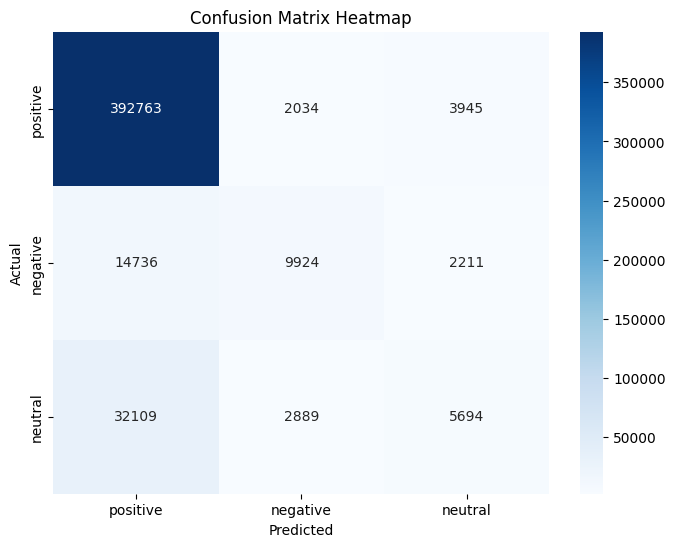

In [44]:
confusion_metric_heatmap(y_test, predictions, classes)

##### Linear Regression

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [46]:
# preprocess text, remove punctuation, upper case, stop words
def preprocess_text(text):
    text = text.lower()
    text= ''.join(c for c in text if c not in string.punctuation)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

review_Hawaii_feature['text'] = review_Hawaii_feature['text'].apply(preprocess_text)

C:\Users\79250\AppData\Local\Temp\ipykernel_75644\4080666143.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_Hawaii_feature['text'] = review_Hawaii_feature['text'].apply(preprocess_text)


In [47]:
vectorizer = CountVectorizer(max_features=2000)  # Convert text to bag-of-words representation
X = vectorizer.fit_transform(review_Hawaii_feature["text"])

y = review_Hawaii_feature["rating"]

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [50]:
mse_BOW_LinearRegression_train = MSE(model.predict(X_train), y_train)
mse_BOW_LinearRegression_train

0.6238895054544062

In [51]:
# Predict 
y_pred = model.predict(X_test)
mse_BOW_LinearRegression = MSE(y_test, y_pred)
print("Mean Squared Error:", mse_BOW_LinearRegression)

Mean Squared Error: 0.6281887058220773


In [52]:
# Get word weights from the model
weights = model.coef_
vocab = vectorizer.get_feature_names_out()
word_weights = dict(zip(vocab, weights))

# Display top 10 words with the highest weights
sorted_words = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)
print("Top 10 words with highest weights:")
for word, weight in sorted_words[:10]:
    print(f"{word}: {weight:.4f}")

print("\nTop 10 words with lowest weights:")
for word, weight in sorted_words[-10:]:
    print(f"{word}: {weight:.4f}")

Top 10 words with highest weights:
awsome: 0.4336
reasonably: 0.3961
awesome: 0.3270
excellent: 0.2964
heaven: 0.2899
onolicious: 0.2879
breathtaking: 0.2837
best: 0.2835
beautiful: 0.2766
breath: 0.2763

Top 10 words with lowest weights:
mediocre: -0.7756
dirty: -0.8091
awful: -0.8451
overpriced: -0.8502
sucks: -0.9931
poor: -1.0007
rude: -1.0034
terrible: -1.0250
horrible: -1.1107
worst: -1.1709


###### Word Cloud

In [53]:
from wordcloud import WordCloud

In [54]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)

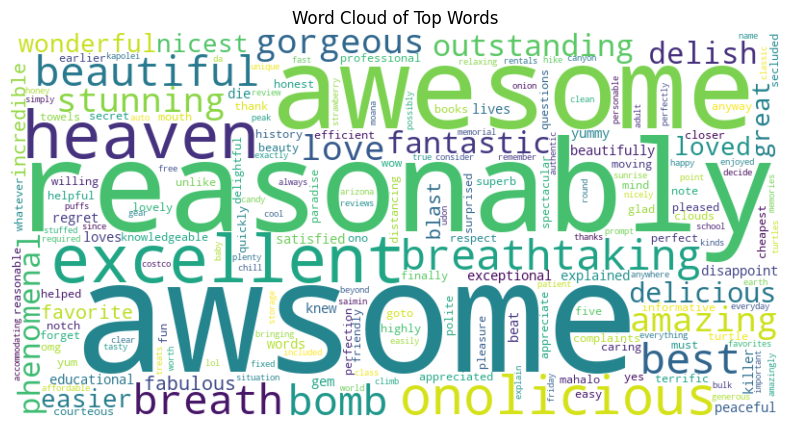

In [55]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Words')
plt.show()

In [56]:
sorted_weights = sorted(word_weights.items(), key=lambda x: x[1])

In [57]:
negative_words = sorted_weights[:10]
positive_words = sorted_weights[-10:]

In [58]:
neg_words, neg_weights = zip(*negative_words)
pos_words, pos_weights = zip(*positive_words)

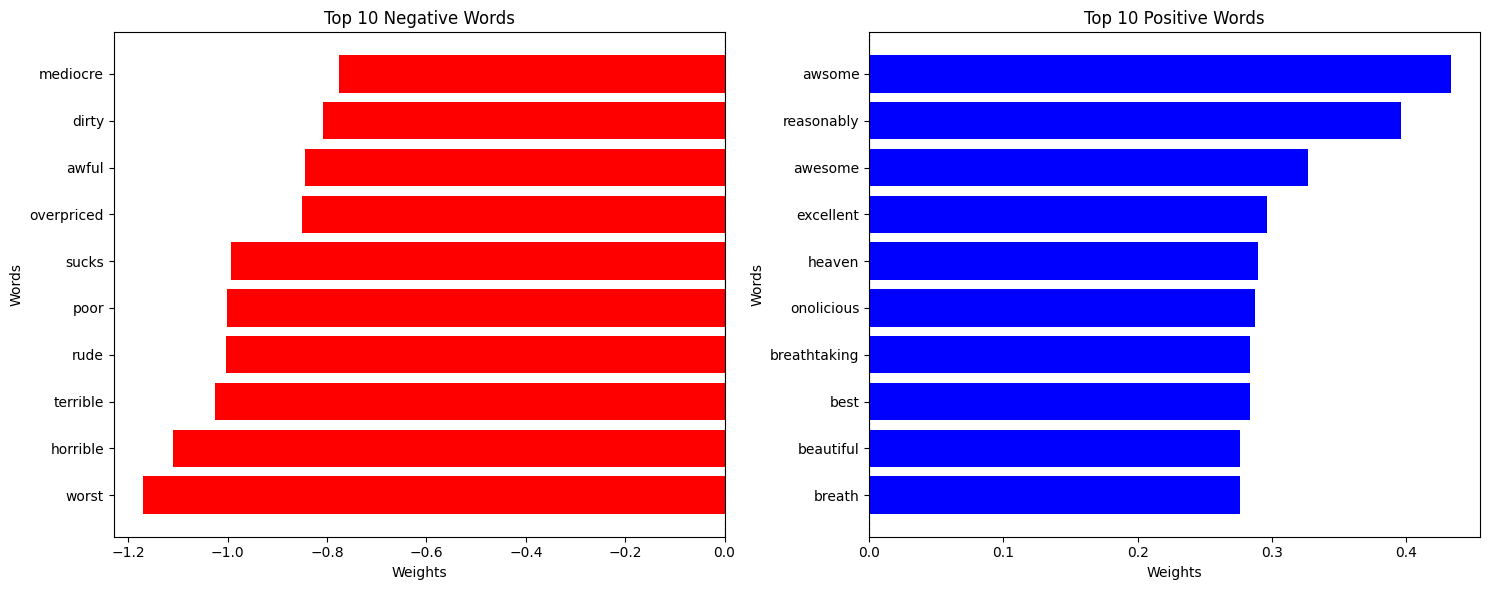

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1]})

axes[0].barh(neg_words, neg_weights, color='red')
axes[0].set_title("Top 10 Negative Words")
axes[0].set_xlabel("Weights")
axes[0].set_ylabel("Words")
axes[0].axvline(0, color='black', linewidth=0.8, linestyle='--')

axes[1].barh(pos_words, pos_weights, color='blue')
axes[1].set_title("Top 10 Positive Words")
axes[1].set_xlabel("Weights")
axes[1].set_ylabel("Words")
axes[1].axvline(0, color='black', linewidth=0.8, linestyle='--') 

plt.tight_layout()
plt.show()

#### 2. TFIDF

##### TFIDF - LinearSVC

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

In [61]:
X = review_Hawaii_feature['text']
y = review_Hawaii_feature['rating']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
tfidf = TfidfVectorizer(sublinear_tf=True, max_features=2000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [64]:
linear_svr = LinearSVC()
linear_svr.fit(X_train_tfidf, y_train)

LinearSVC()

In [65]:
y_pred_train = linear_svr.predict(X_train_tfidf)
y_pred_test = linear_svr.predict(X_test_tfidf)

In [66]:
train_mse = MSE(y_train, y_pred_train)
test_mse = MSE(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")

mse_linearsvc_tfidf = test_mse

Train MSE: 0.82
Test MSE: 0.82


In [67]:
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.6704131476391219
Testing Accuracy: 0.6687039598546016

Classification Report on Test Data:
              precision    recall  f1-score   support

           1       0.52      0.41      0.46      4527
           2       0.37      0.01      0.02      4430
           3       0.45      0.19      0.27     13564
           4       0.45      0.17      0.25     35525
           5       0.71      0.96      0.81     97389

    accuracy                           0.67    155435
   macro avg       0.50      0.35      0.36    155435
weighted avg       0.61      0.67      0.60    155435



##### TFIDF - Ridge Regression(Redundant)

In [68]:
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\79250\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\79250\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\79250\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\79250\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\79250\AppData\Roaming\nltk_data...
[

In [69]:
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize, stop_words='english')

In [70]:
MR_train_X_tfidf, MR_test_X_tfidf, MR_train_Y_tfidf, MR_test_Y_tfidf = train_test_split(X, y, test_size=0.2, random_state=200)
# MR_train_X_tfidf = MR_train_X_tfidf
# MR_test_X_tfidf = MR_test_X_tfidf

In [71]:
MR_train_vector_tfidf = tfidf.fit_transform(MR_train_X_tfidf).toarray()
MR_test_vector_tfidf = tfidf.transform(MR_test_X_tfidf).toarray()
vocabulary_tfidf_train = tfidf.vocabulary_

c:\Users\79250\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [72]:
len(MR_train_vector_tfidf)

621739

In [73]:
alpha = [0.1, 0.5, 1 , 5, 10, 50, 100]

In [74]:
best_MSE = None
best_alpha = None
for a in alpha:
    clf = linear_model.Ridge(a, fit_intercept=False) # MSE + 1.0 l2
    clf.fit(MR_train_vector_tfidf, MR_train_Y_tfidf)
    predictions_tfidf = clf.predict(MR_test_vector_tfidf).clip(1, 5)
    mse = MSE(MR_test_Y_tfidf, predictions_tfidf)
    print(f"Alpha: {a}, MSE: {mse}")
    if best_alpha is None or mse < best_MSE:
        best_alpha = a
        best_MSE = mse

Alpha: 0.1, MSE: 1.790179638169582
Alpha: 0.5, MSE: 1.790733553231256
Alpha: 1, MSE: 1.7914300398044054
Alpha: 5, MSE: 1.797121925455974
Alpha: 10, MSE: 1.8044595648337662
Alpha: 50, MSE: 1.8666162947519673
Alpha: 100, MSE: 1.9433707679040746


##### TFIDF - Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression

In [76]:
linear_model_tfidf = LinearRegression()
linear_model_tfidf.fit(MR_train_vector_tfidf, MR_train_Y_tfidf)

LinearRegression()

In [77]:
linear_predictions = linear_model_tfidf.predict(MR_test_vector_tfidf).clip(1, 5)
mse_linear_reg_tfidf = MSE(MR_test_Y_tfidf, linear_predictions)

print(f"Linear Regression MSE: {mse_linear_reg_tfidf}")

Linear Regression MSE: 0.5592757216596443


In [78]:
mse_linear_reg_tfidf_train = MSE(linear_model_tfidf.predict(MR_train_vector_tfidf), MR_train_Y_tfidf)
mse_linear_reg_tfidf_train

0.5678614185142206

##### TFIDF - SGDRegressor

In [79]:
from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)
sgd_model.fit(MR_train_vector_tfidf, MR_train_Y_tfidf)

SGDRegressor()

In [80]:
sgd_model_predictions = sgd_model.predict(MR_test_vector_tfidf).clip(1, 5)
mse_sgd_tfidf = MSE(MR_test_Y_tfidf, sgd_model_predictions)

print(f"SGD Regression MSE: {mse_sgd_tfidf}")

SGD Regression MSE: 0.5834898968825037


In [81]:
mse_sgd_tfidf_train = MSE(sgd_model.predict(MR_train_vector_tfidf), MR_train_Y_tfidf)
mse_sgd_tfidf_train

0.5932653000469439

#### 3. Latent Factor Model

##### Baseline Model

In [82]:
from surprise import Dataset, Reader
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import BaselineOnly

In [83]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(review_Hawaii_feature[['user_id', 'gmap_id', 'rating']], reader)

In [84]:
trainset, testset = train_test_split(data, test_size=0.2)

In [85]:
baseline_model = BaselineOnly()
baseline_model.fit(trainset)

Estimating biases using als...


In [86]:
baseline_predictions = baseline_model.test(testset)
mse_baseline_LF = MSE([d.r_ui for d in baseline_predictions], [d.est for d in baseline_predictions])

print(f"Baseline MSE: {mse_baseline_LF}")

Baseline MSE: 0.7458101950154591


In [87]:
train_predictions = baseline_model.test(trainset.build_testset())
mse_baseline_LF_train = MSE([d.r_ui for d in train_predictions], [d.est for d in train_predictions])

In [88]:
mse_baseline_LF_train

0.6739243669871912

##### SVD++

In [89]:
param_grid = {
    'n_factors': [20, 50, 100],
    'lr_all': [0.01, 0.1, 0.5],
    'reg_all': [0.05, 0.1, 0.2]
}

In [90]:
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, n_jobs=-1, joblib_verbose=2)

In [91]:
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
c:\Users\79250\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 10.3min finished


In [92]:
# Train SVD++ using optimal parameters
best_params = gs.best_params['rmse']
model = SVDpp(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
model.fit(trainset)

In [93]:
predictions = model.test(testset)
mse_best_SVDpp = MSE([p.r_ui for p in predictions], [p.est for p in predictions])

print(f"Best parameters: {best_params}")
print(f"Test MSE: {mse_best_SVDpp}")

Best parameters: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.1}
Test MSE: 0.7273318947969469


In [94]:
predictions_train = model.test(trainset.build_testset())
mse_best_SVDpp_train = MSE([p.r_ui for p in predictions_train], [p.est for p in predictions_train])
mse_best_SVDpp_train

0.4807358822742618

##### Random Forest Regressor

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X = review_Hawaii_feature['text']
y = review_Hawaii_feature['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
rf_model = RandomForestRegressor(n_estimators=20, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [100]:
# Make predictions on the test set
y_pred_test = rf_model.predict(X_test_tfidf)
mse_RFR_test = MSE(y_test, y_pred_test)
mse_RFR_test
y_pred_train = rf_model.predict(X_train_tfidf)
mse_RFR_train = MSE(y_train, y_pred_train)
mse_RFR_train

0.17226251926432395

#### Bi-GRU

##### Random Initialization

In [101]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [102]:
# Step 1: Preprocessing
max_words = 20000  # Vocabulary size
max_len = 100      # Maximum sequence length

# Tokenizing text
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [103]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [104]:
# Step 2: Load GloVe Embeddings
embedding_dim = 100
embedding_index = {}

In [105]:
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coef

In [106]:
# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

In [107]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [108]:
# Step 3: Build Bi-GRU Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='linear')
])

c:\Users\79250\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [109]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [110]:
# Step 4: Train the Model
history = model.fit(X_train, y_train,
                    epochs=1,
                    batch_size=32,
                    validation_data=(X_test, y_test))

19430/19430 ━━━━━━━━━━━━━━━━━━━━ 1553s 80ms/step - loss: 0.6030 - mae: 0.5452 - val_loss: 0.4390 - val_mae: 0.4565


In [111]:
train_mse_gru = history.history['loss'][0]
train_mse_gru

0.4918878376483917

In [112]:
bi_gur_predictions = model.predict(X_test).flatten()

4858/4858 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step


In [113]:
mse_bi_gru = MSE(y_test, bi_gur_predictions)

print(f"Bi-GRU MSE: {mse_bi_gru}")

Bi-GRU MSE: 0.43903648275667145


##### With GloVe Embeddings

In [114]:
model_gloVe = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=num_words, 
        output_dim=embedding_dim, 
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='linear')
])

In [115]:
model_gloVe.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [116]:
history_gloVe = model_gloVe.fit(X_train, y_train,
                    epochs=1,
                    batch_size=32,
                    validation_data=(X_test, y_test))

19430/19430 ━━━━━━━━━━━━━━━━━━━━ 1271s 65ms/step - loss: 0.5768 - mae: 0.5348 - val_loss: 0.4325 - val_mae: 0.4591


In [140]:
bigur_glove_mse_train = history_gloVe.history['loss'][0]
bigur_glove_mse_train

0.47923797369003296

In [118]:
bigur_glove_predictions = model_gloVe.predict(X_test).flatten()

4858/4858 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step


In [119]:
bigur_glove_mse = MSE(y_test, bigur_glove_predictions)

print(f"Bi-GRU with GloVe MSE: {bigur_glove_mse}")

Bi-GRU with GloVe MSE: 0.43254373160372317


#### Result Analysis

In [120]:
models_name = ['Jaccard User-based', 'Cosine User-based',  'Bag-of-Words Linear Regression', 'TF-IDF Linear Regression', 'TF-IDF SGD Regression', 'Baseline Latent Factor', 'SVD++', 'Bi-GRU with GloVe', 'Random Forest']
models_mse = [mse_best_jaccard, mse_consin_user, mse_bg_ridge, mse_linear_reg_tfidf, mse_sgd_tfidf, mse_baseline_LF, mse_best_SVDpp, bigur_glove_mse, 0.591997]

In [121]:
sorted_indices = sorted(range(len(models_mse)), key=lambda i: models_mse[i], reverse=True)
models_name_sorted = [models_name[i] for i in sorted_indices]
models_mse_sorted = [models_mse[i] for i in sorted_indices]

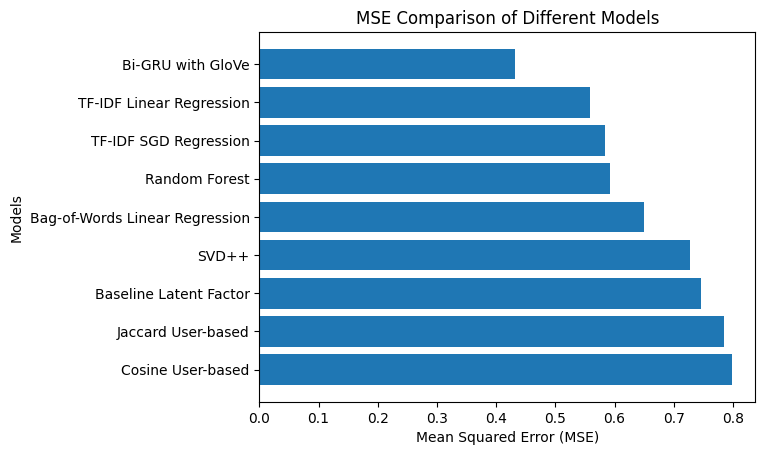

In [122]:
plt.barh(models_name_sorted, models_mse_sorted)
plt.title('MSE Comparison of Different Models')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Models')
plt.show()

| **Model**                     | **Strengths**                                                  | **Limitations**                                                 | **Predictions**                                                 |
|-------------------------------|--------------------------------------------------------------|---------------------------------------------------------------|----------------------------------------------------------------|
| **Bi-GRU with GloVe**         | Captures sequence and context; uses semantic embeddings.     | Computationally intensive.                                     | Best predictions with nuanced sentiment understanding.         |
| **TF-IDF Linear Regression**  | Simple and interpretable; leverages word importance.         | Ignores word order and context.                               | Moderate performance, relies on effective feature engineering. |
| **TF-IDF SGD Regression**     | Scalable and flexible.                                       | Optimization variability; lacks sequence modeling.            | Similar to linear regression but slightly less stable.         |
| **Random Forest**             | Captures non-linear relationships; robust ensemble.         | Ignores word order and textual context.                       | Moderate, struggles with complex text relationships.           |
| **Bag-of-Words Regression**   | Simple and computationally efficient.                       | Ignores context and sequence entirely.                        | Poor performance, loses meaning in nuanced text.               |
| **SVD++**                     | Captures latent factors in user-item interactions.          | Does not utilize text.                                        | Ineffective for text-based prediction tasks.                   |
| **Jaccard & Cosine Similarity**| Simple similarity-based collaborative filtering.            | Ignores textual data entirely.                                | Worst performance, cannot predict from text.                   |


In [141]:
models_name = ['Jaccard User-based', 'Cosin User-based', 'Bag-of-Words Linear Regression', 'TF-IDF Linear Regression', 'TF-IDF SGD Regression', 'Baseline Latent Factor', 'SVD++', 'Random Forest Regression', 'Bi-GRU with GloVe']

models_mse = [mse_jaccard_user, mse_consin_user, mse_bg_ridge, mse_linear_reg_tfidf, mse_sgd_tfidf, mse_baseline_LF, mse_best_SVDpp, mse_RFR_test, bigur_glove_mse]

models_mse_train = [mse_jaccard_user_train,
                    mse_cosin_user_train,
                    mse_bg_ridge_train, 
                    mse_linear_reg_tfidf_train, 
                    mse_sgd_tfidf_train, 
                    mse_baseline_LF_train, 
                    mse_best_SVDpp_train,
                    mse_RFR_train,
                    bigur_glove_mse_train]

In [142]:
data = {'Model': models_name,
        'Train MSE': models_mse_train, 
        'Test MSE': models_mse}

df = pd.DataFrame(data)
print(df)

                            Model  Train MSE  Test MSE
0              Jaccard User-based   0.732771  0.803355
1                Cosin User-based   0.705648  0.798150
2  Bag-of-Words Linear Regression   0.647158  0.649894
3        TF-IDF Linear Regression   0.567861  0.559276
4           TF-IDF SGD Regression   0.593265  0.583490
5          Baseline Latent Factor   0.673924  0.745810
6                           SVD++   0.480736  0.727332
7        Random Forest Regression   0.172263  0.594458
8               Bi-GRU with GloVe   0.479238  0.432544


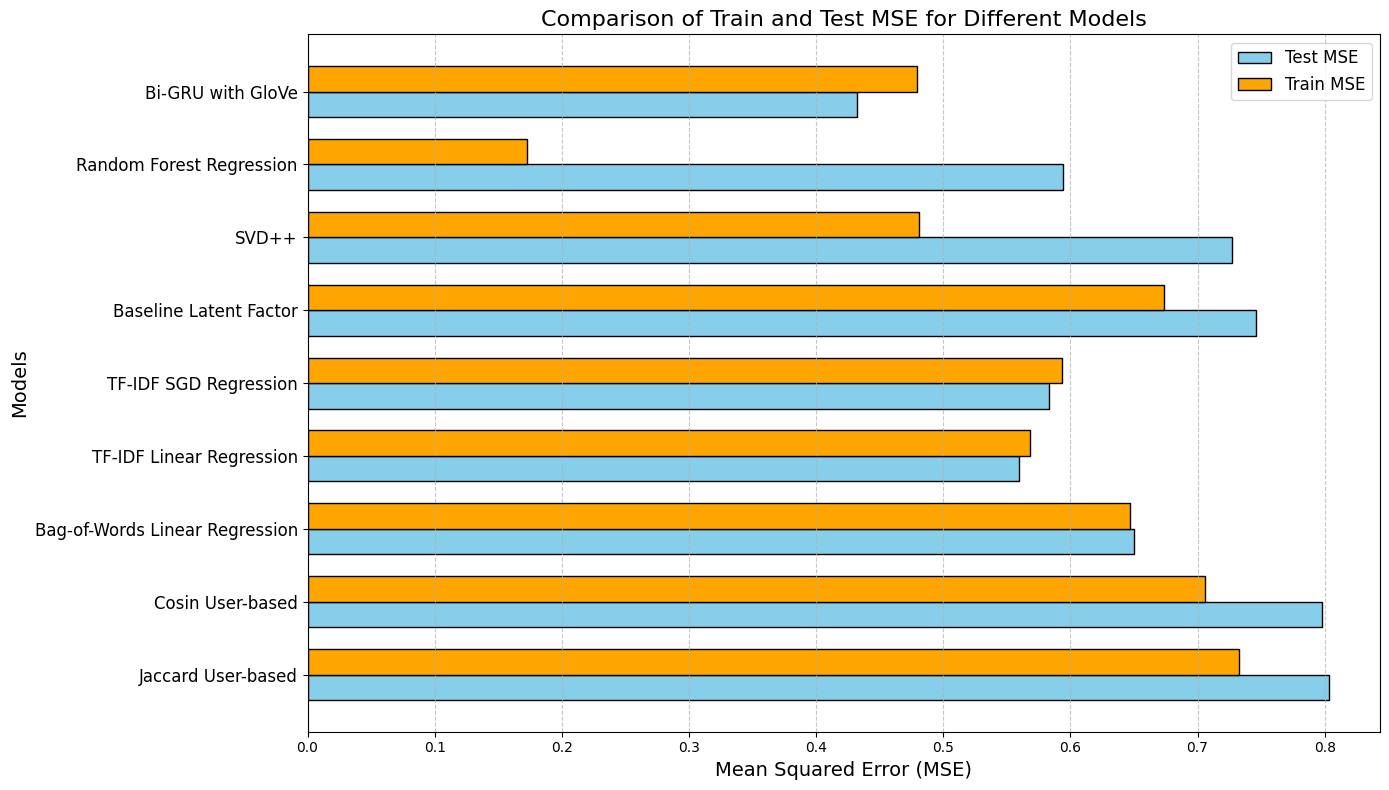

In [143]:
# Plotting parameters
bar_width = 0.35
index = np.arange(len(models_name))

# Create a horizontal bar plot
plt.figure(figsize=(14, 8))
plt.barh(index, models_mse, bar_width, label='Test MSE', color='skyblue', edgecolor='black')
plt.barh(index + bar_width, models_mse_train, bar_width, label='Train MSE', color='orange', edgecolor='black')

# Add labels and title
plt.xlabel('Mean Squared Error (MSE)', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.title('Comparison of Train and Test MSE for Different Models', fontsize=16)
plt.yticks(index + bar_width / 2, models_name, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()